In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.instance().ast_node_interactivity = "all"

In [2]:
import math

import torch
import torch.nn as nn
from lightning import LightningModule

torch.set_float32_matmul_precision("medium")  # 推荐选项


# ==============================================================================
# 依赖的辅助模块和基类
# ==============================================================================


class FourierFeatures(nn.Module):
    """
    将标量t编码为傅里叶特征
    """

    def __init__(self, input_dim: int, mapping_size: int, scale: float = 10.0):
        super().__init__()
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        # 使用 register_buffer 是更规范的做法，因为它不是一个需要训练的参数
        self.register_buffer("B", torch.randn((input_dim, mapping_size)) * scale)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        if t.dim() == 1:
            t = t.unsqueeze(1)
        # 确保 t 是 float 类型
        t = t.float()
        # 核心操作: (batch_size, 1) @ (1, mapping_size) -> (batch_size, mapping_size)
        x_proj = 2 * math.pi * t @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class BaseModel(LightningModule):
    """
    模型基类，包含通用的训练和优化逻辑
    """

    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.loss_fn = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        x, t, y = batch
        y_hat = self.forward(x, t)
        loss = self.loss_fn(y_hat, y)
        self.log("train/loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, y = batch
        y_hat = self.forward(x, t)
        loss = self.loss_fn(y_hat, y)
        self.log("val/loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, t, y = batch
        y_hat = self.forward(x, t)
        loss = self.loss_fn(y_hat, y)
        self.log("test/loss", loss, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, t, y = batch
        y_hat = self.forward(x, t)
        # v 代表真值y
        return t, y, y_hat

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


# ==============================================================================
# FourierMLPModel
# ==============================================================================


class FourierMLPModel(BaseModel):
    def __init__(
        self, x_dim: int, hidden_dim: int, num_layers: int, fourier_mapping_size: int, learning_rate: float = 1e-3
    ):
        super().__init__(learning_rate)
        self.save_hyperparameters()  # 保存所有超参数

        # 1. 创建t的傅里叶编码器
        self.fourier_encoder = FourierFeatures(input_dim=1, mapping_size=fourier_mapping_size)

        # 傅里叶特征的输出维度是 mapping_size * 2
        fourier_output_dim = fourier_mapping_size * 2

        # 2. 计算拼接后送入MLP的总维度
        total_input_dim = x_dim + fourier_output_dim

        # 3. 动态构建MLP层
        layers = []
        # 输入层
        layers.append(nn.Linear(total_input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # 隐藏层
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # 输出层
        layers.append(nn.Linear(hidden_dim, 1))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # a. 对 t 进行编码
        t_encoded = self.fourier_encoder(t)

        # b. 拼接 X 和编码后的 t
        combined_input = torch.cat([x, t_encoded], dim=-1)

        # c. 通过 MLP 进行预测
        y_hat = self.mlp(combined_input)
        return y_hat


# ==============================================================================
# DecompositionModel
# ==============================================================================


class FourierDecompositionModel(BaseModel):
    def __init__(
        self,
        x_dim: int,
        hidden_dim: int,
        interaction_dim: int,
        t_encoding_method: str = "fourier",  # 'fourier', 'fc', or 'none'
        fourier_mapping_size: int = 32,
        t_embedding_dim: int = 64,
        learning_rate: float = 1e-3,
    ):
        super().__init__(learning_rate)
        self.save_hyperparameters()  # 保存所有超参数

        # --- 动态定义 t 的编码器和输入维度 ---
        self.t_encoder = None
        t_input_dim = 1

        if t_encoding_method == "fourier":
            self.t_encoder = FourierFeatures(input_dim=1, mapping_size=fourier_mapping_size)
            t_input_dim = fourier_mapping_size * 2
            print(f"使用傅里叶特征编码t，编码后维度: {t_input_dim}")
        elif t_encoding_method == "fc":
            self.t_encoder = nn.Sequential(nn.Linear(1, t_embedding_dim), nn.ReLU())
            t_input_dim = t_embedding_dim
            print(f"使用可学习的FC层编码t，编码后维度: {t_input_dim}")
        elif t_encoding_method == "none":
            print("不使用任何编码，直接输入t。")
        else:
            raise ValueError("t_encoding_method 必须是 'fourier', 'fc', 或 'none'")

        # --- 定义模型的其余部分 ---
        # f_x(X) 部分
        self.f_x = nn.Sequential(nn.Linear(x_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

        # f_t 和 g_t 部分，它们的输入维度由上面的逻辑决定
        self.f_t = nn.Sequential(nn.Linear(t_input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
        self.g_x = nn.Sequential(nn.Linear(x_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, interaction_dim))
        self.g_t = nn.Sequential(nn.Linear(t_input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, interaction_dim))

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # 确保 t 的维度正确
        if t.dim() == 1:
            t = t.unsqueeze(1)

        # --- 根据所选方法对 t 进行编码 ---
        if self.t_encoder is not None:
            t_encoded = self.t_encoder(t)
        else:
            t_encoded = t  # 'none' 模式

        # --- 计算模型输出 ---
        fx_out = self.f_x(x)
        ft_out = self.f_t(t_encoded)
        gx_out = self.g_x(x)
        gt_out = self.g_t(t_encoded)

        interaction = (gx_out * gt_out).sum(dim=1, keepdim=True)

        y_hat = fx_out + ft_out + interaction
        return y_hat


In [3]:
from typing import Tuple

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset


class DOSDataset(Dataset):
    """
    将 desc(DataFrame), dos_energy(Series of list), dos(Series of list) 展开为 (D_j, t^j_i, v^j_i) 样本
    """

    def __init__(self, desc: pd.DataFrame, dos_energy: pd.Series, dos: pd.Series):
        super().__init__()
        self.samples = []
        # 遍历所有样本
        for idx in desc.index.intersection(dos.index).intersection(dos_energy.index):
            D_j = torch.tensor(desc.loc[idx].values, dtype=torch.float32)
            t_list = dos_energy.loc[idx]
            v_list = dos.loc[idx]
            # 保证长度一致
            if len(t_list) != len(v_list):
                continue
            for t_i, v_i in zip(t_list, v_list):
                t_tensor = torch.tensor([t_i], dtype=torch.float32)  # (1,)
                v_tensor = torch.tensor([v_i], dtype=torch.float32)  # (1,)
                self.samples.append((D_j, t_tensor, v_tensor))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.samples[idx]

In [4]:
from typing import Optional

import lightning as pl
import numpy as np


class DOSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        desc: pd.DataFrame,
        dos_energy: pd.Series,
        dos: pd.Series,
        serial: Optional[pd.Series] = None,  # index->"train"/"val"/"test"
        batch_size: int = 32,
        random_seed: int = 42,
    ):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        self.serial = serial
        self.batch_size = batch_size
        self.random_seed = random_seed

    def setup(self, stage=None):
        if self.serial is not None:
            train_idx = self.serial[self.serial == "train"].index
            val_idx = self.serial[self.serial == "val"].index
            test_idx = self.serial[self.serial == "test"].index
        else:
            # 自动划分
            all_idx = np.array(list(self.desc.index.intersection(self.dos.index).intersection(self.dos_energy.index)))
            rng = np.random.RandomState(self.random_seed)
            perm = rng.permutation(len(all_idx))
            n = len(all_idx)
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)
            # n_test = n - n_train - n_val  # 未被使用，可删除
            train_idx = all_idx[perm[:n_train]]
            val_idx = all_idx[perm[n_train : n_train + n_val]]
            test_idx = all_idx[perm[n_train + n_val :]]
        self.train_dataset = DOSDataset(
            self.desc.loc[train_idx], self.dos_energy.loc[train_idx], self.dos.loc[train_idx]
        )
        self.val_dataset = DOSDataset(self.desc.loc[val_idx], self.dos_energy.loc[val_idx], self.dos.loc[val_idx])
        self.test_dataset = DOSDataset(self.desc.loc[test_idx], self.dos_energy.loc[test_idx], self.dos.loc[test_idx])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [5]:
import random

import matplotlib.pyplot as plt
import torch


def plot_prediction_pairs(samples, *, n=9, seed=42, prop="", title_prefix="Sample", show_true=True, show_pred=True):
    """
    输入 samples: List of (t, v_true) 或 (t, v_true, v_pred)
    自动判断有无 pred，进行单曲线或对比绘图
    只取每条曲线中间90%的数据进行绘制
    show_true: 是否绘制真实曲线
    show_pred: 是否绘制预测曲线
    额外输出本次抽中的indices
    """
    random.seed(seed)  # 固定随机种子以确保可重复性

    indices = random.sample(range(len(samples)), n)
    print("plot_prediction_pairs indices:", indices)  # 输出抽中的indices
    n_cols = int(np.sqrt(n))
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        entry = samples[idx]
        if len(entry) == 2:
            t, v_true = entry
            v_pred = None
        elif len(entry) == 3:
            t, v_true, v_pred = entry
        else:
            raise ValueError("Each sample must be (t, v_true) or (t, v_true, v_pred)")

        t = t.squeeze(-1).cpu().numpy()
        v_true = v_true.squeeze(-1).cpu().numpy()
        n_points = len(t)
        start = int(n_points * 0.05)
        end = int(n_points * 0.95)
        t_mid = t[start:end]
        v_true_mid = v_true[start:end]

        ax = axes[i]
        if show_true:
            ax.plot(t_mid, v_true_mid, label="True", linewidth=1.5)
        if show_pred and v_pred is not None:
            v_pred = v_pred.squeeze(-1).cpu().numpy()
            v_pred_mid = v_pred[start:end]
            ax.plot(t_mid, v_pred_mid, label="Pred", linewidth=1.5)
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel(prop)
        ax.legend()

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
import joblib
import pandas as pd
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250529.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250529.pd.parquet")

In [9]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

prop = _[1]

prop_value = qc_ac_te_mp_dos_data[prop].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop} (T/K)"].loc[prop_value.index]
    if prop != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)
desc = desc_trans.loc[prop_value.index]
split = qc_ac_te_mp_dos_data["split"].loc[prop_value.index]

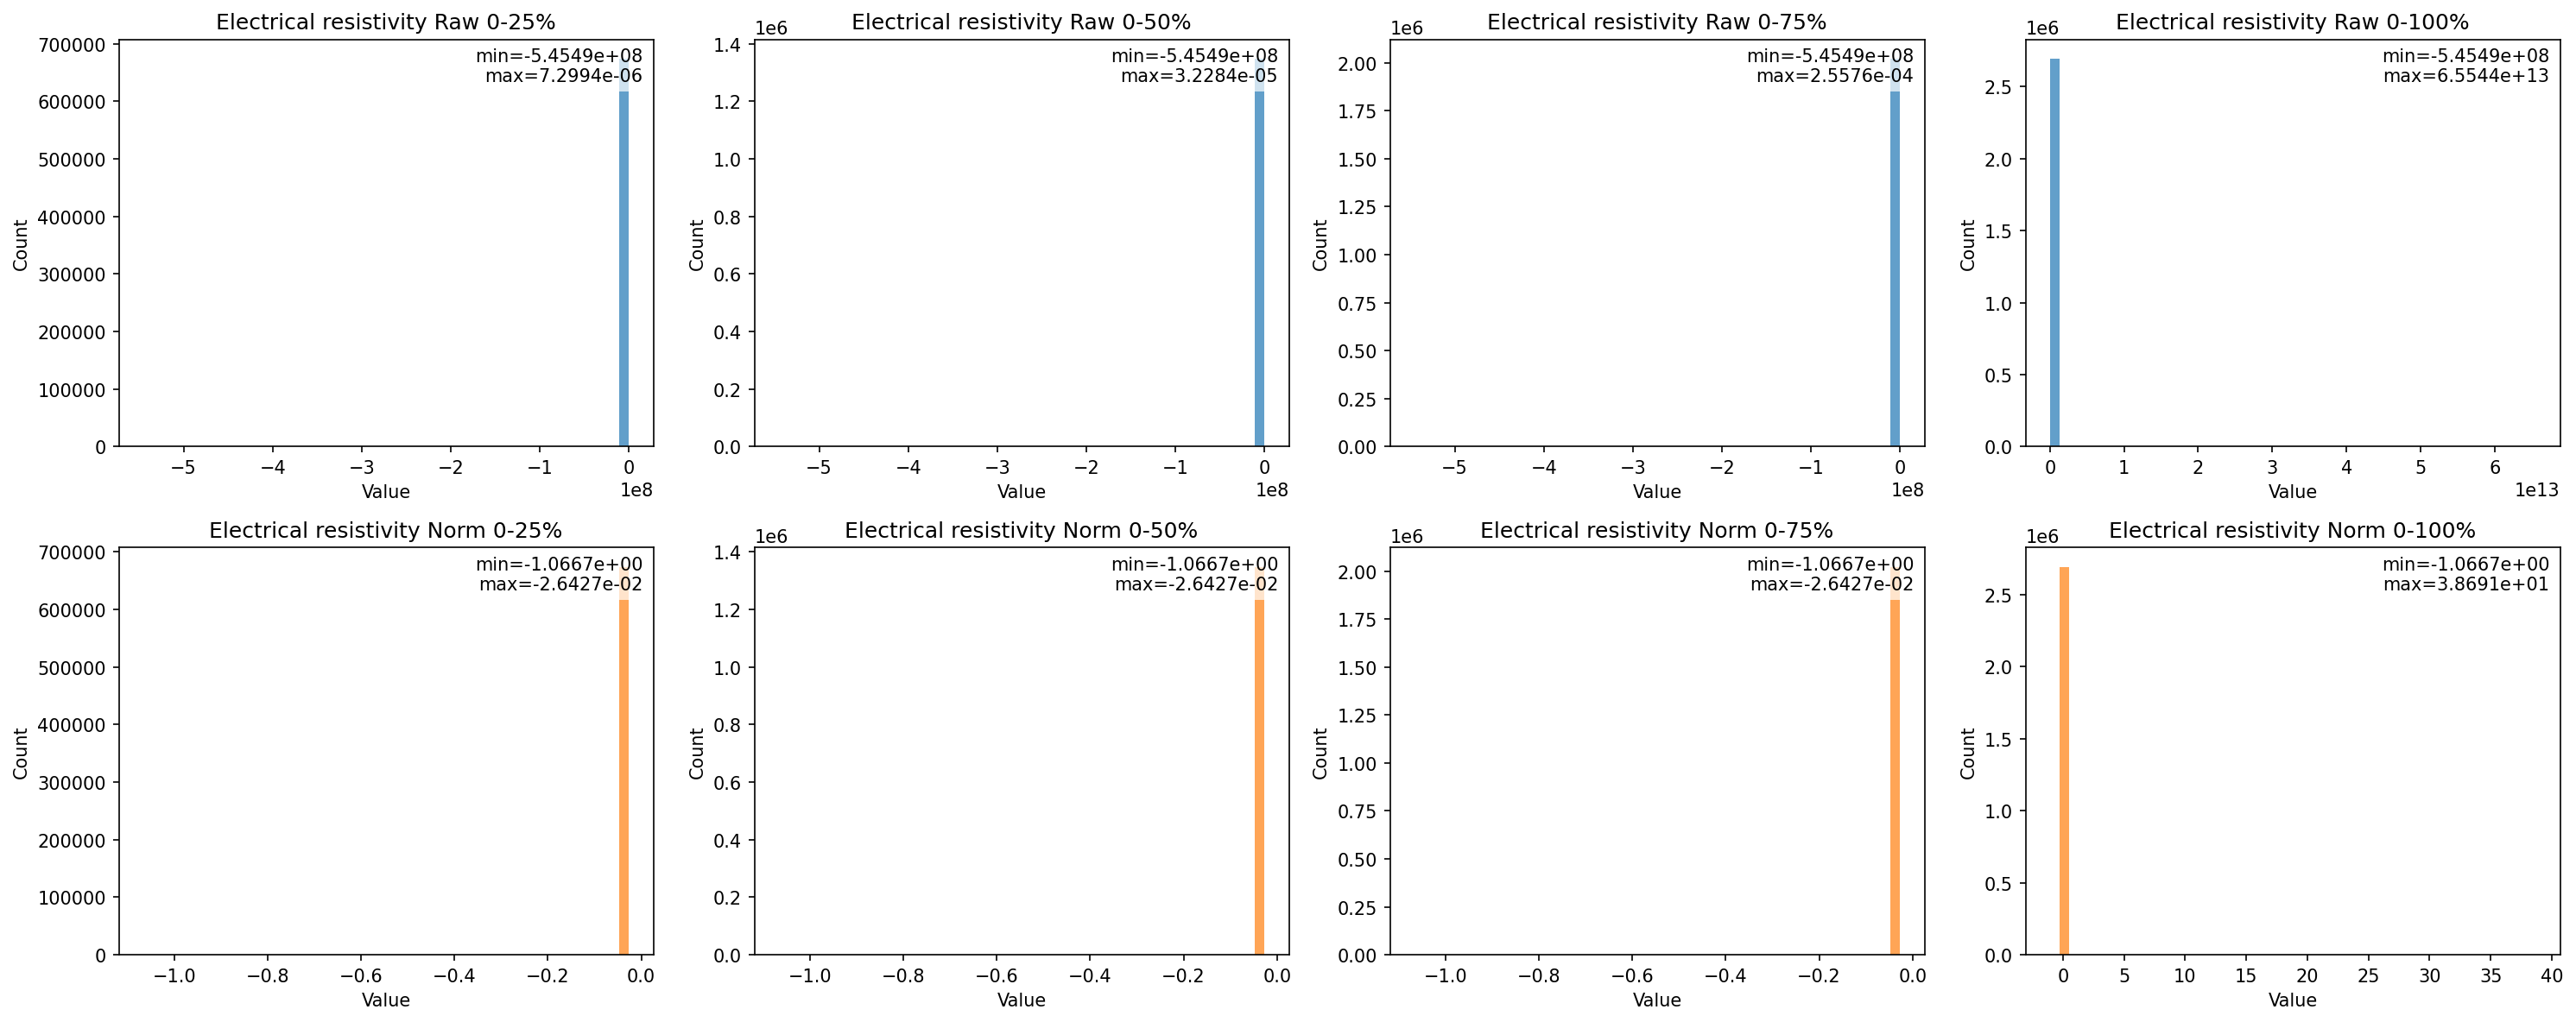

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), dpi=150)
percentiles = [0.25, 0.5, 0.75, 1.0]
titles = ["0-25%", "0-50%", "0-75%", "0-100%"]

for row, data_series in enumerate([prop_value, prop_value_norm]):
    a = np.concatenate([i for i in data_series])
    a_sorted = np.sort(a)
    n = len(a_sorted)
    for col, p in enumerate(percentiles):
        end = int(n * p)
        data_slice = a_sorted[:end]
        ax = axes[row, col]
        _ = ax.hist(data_slice, bins=50, color="C0" if row == 0 else "C1", alpha=0.7)
        min_val, max_val = data_slice.min(), data_slice.max()
        _ = ax.set_title(f"{prop} {'Raw' if row == 0 else 'Norm'} {titles[col]}")
        _ = ax.text(
            0.98,
            0.98,
            f"min={min_val:.4e}\nmax={max_val:.4e}",
            ha="right",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
        _ = ax.set_xlabel("Value")
        _ = ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Experiment 1: Fourier feature encoding ---
使用傅里叶特征编码t，编码后维度: 64

--- Experiment 2: FC layer encoding ---
使用可学习的FC层编码t，编码后维度: 64

--- Experiment 3: No encoding (baseline) ---
不使用任何编码，直接输入t。

Model to be trained: fc encoding


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | loss_fn   | MSELoss    | 0      | train
1 | t_encoder | Sequential | 128    | train
2 | f_x       | Sequential | 37.4 K | train
3 | f_t       | Sequential | 8.4 K  | train
4 | g_x       | Sequential | 45.5 K | train
5 | g_t       | Sequential | 16.6 K | train
-------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.432     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 2109/2109 [00:33<00:00, 62.54it/s, v_num=2, train/loss_step=0.0146, val/loss=0.0263, train/loss_epoch=0.0158]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2109/2109 [00:33<00:00, 62.51it/s, v_num=2, train/loss_step=0.0146, val/loss=0.0263, train/loss_epoch=0.0158]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 469/469 [00:01<00:00, 418.78it/s]
plot_prediction_pairs indices: [1309, 228, 51, 1518, 563, 501, 457, 285, 1508]


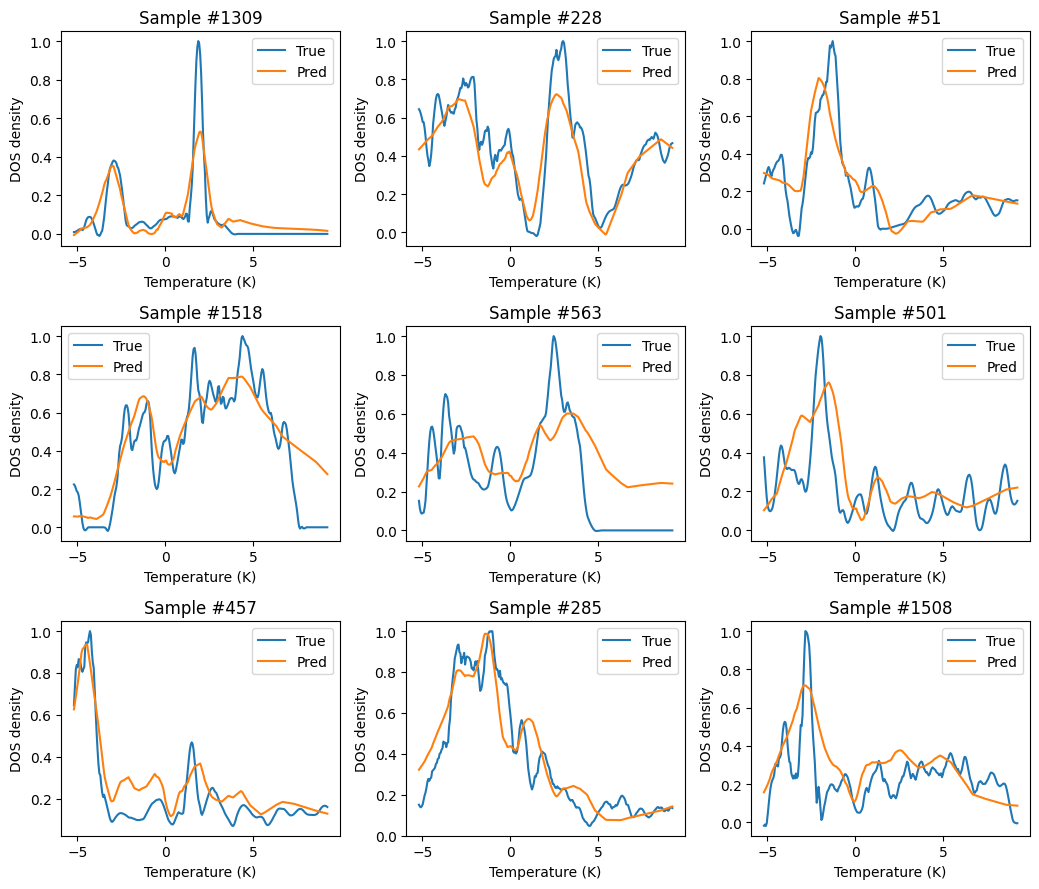

In [11]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

LR_RATE = 5e-4
HIDDEN_DIM = 128
INTERACTION_DIM = 64
BATCH_SIZE = 1024
EPOCHS = 20

# 1. Initialize data module
dm = DOSDataModule(
    desc=desc,
    dos_energy=prop_T,
    dos=prop_value_norm,
    serial=split,
    batch_size=BATCH_SIZE,
    random_seed=42,
)
dm.setup()

# 2. Initialize models
# --- Switch model configuration with one line for comparison experiments ---

# Experiment 1: Use Fourier features
print("\n--- Experiment 1: Fourier feature encoding ---")
model_fourier = FourierDecompositionModel(
    x_dim=desc.shape[1],
    hidden_dim=HIDDEN_DIM,
    interaction_dim=INTERACTION_DIM,
    t_encoding_method="fourier",
    fourier_mapping_size=32,
    learning_rate=LR_RATE,
)

# Experiment 2: Use learnable FC layer
print("\n--- Experiment 2: FC layer encoding ---")
model_fc = FourierDecompositionModel(
    x_dim=desc.shape[1],
    hidden_dim=HIDDEN_DIM,
    interaction_dim=INTERACTION_DIM,
    t_encoding_method="fc",
    t_embedding_dim=64,  # 64 = 32 * 2, to match the dimension of Fourier features
    learning_rate=LR_RATE,
)

# Experiment 3: No encoding (baseline)
print("\n--- Experiment 3: No encoding (baseline) ---")
model_none = FourierDecompositionModel(
    x_dim=desc.shape[1],
    hidden_dim=HIDDEN_DIM,
    interaction_dim=INTERACTION_DIM,
    t_encoding_method="none",
    learning_rate=LR_RATE,
)

# Select a model to train (e.g., choose the 'fourier' version)
model_to_train = model_fc
print(f"\nModel to be trained: {model_to_train.hparams.t_encoding_method} encoding")

# 3. Initialize trainer
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    save_top_k=1,
    mode="min",
    filename="best-{epoch:02d}-{val_loss:.4f}",
)

trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator="auto",
    callbacks=[
        EarlyStopping(monitor="val/loss", patience=10, mode="min"),
        # checkpoint_callback,
    ],
    log_every_n_steps=100,
)

# 4. Start training
trainer.fit(model_to_train, datamodule=dm)

# 5. Predict
preds = trainer.predict(model_to_train, dataloaders=dm.test_dataloader())

# 6. Visualize prediction results
# Concatenate results from all batches
all_t = []
all_v = []
all_y_hat = []
for batch in preds:
    t, v, y_hat = batch
    all_t.append(t)
    all_v.append(v)
    all_y_hat.append(y_hat)
all_t = torch.cat(all_t, dim=0)
all_v = torch.cat(all_v, dim=0)
all_y_hat = torch.cat(all_y_hat, dim=0)

# Assume each D corresponds to a sequence length of 300
seq_len = 300
num_samples = all_t.shape[0] // seq_len

samples = []
for i in range(num_samples):
    t_seq = all_t[i * seq_len : (i + 1) * seq_len]
    v_seq = all_v[i * seq_len : (i + 1) * seq_len]
    y_hat_seq = all_y_hat[i * seq_len : (i + 1) * seq_len]
    samples.append((t_seq, v_seq, y_hat_seq))
plot_prediction_pairs(samples, n=9, prop=prop, show_pred=True)

In [ ]:
s = split[split == "test"]